In [6]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture)

plt.style.use('ggplot')

In [7]:
def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x

N = 500  # number of data points
D = 2  # dimensionality of data

x_train = build_toy_dataset(N)

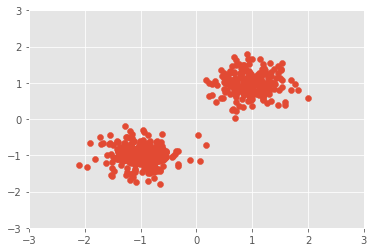

In [8]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()

In [12]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture

K = 2  # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

In [13]:
T = 500  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

In [14]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 71s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.16312766 -0.15503107]
 [ 1.00229502  0.0276818 ]]
 10/500 [  2%]                                ETA: 41s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.16045374 -0.16355748]
 [ 0.00977707 -0.25580284]]
 15/500 [  3%]                                ETA: 28s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.16461243 -0.16140272]
 [-0.03762757 -0.32173052]]
 20/500 [  4%] █                              ETA: 22s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.16315876 -0.15682991]
 [-0.12431224 -0.36156958]]
 25/500 [  5%] █                              ETA: 18s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.15769167 -0.15403664]
 [-0.13913362 -0.27747202]]
 30/500 [  6%] █                              ETA: 15s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.1586812  -0.15430233]
 [-0.20650002 -0.21838765]]
 35/500 [  7%] ██                             

265/500 [ 53%] ███████████████                ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.82910651 -0.81489015]
 [ 0.78999877  0.81671071]]
270/500 [ 54%] ████████████████               ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.83225524 -0.81829333]
 [ 0.79314369  0.81997788]]
275/500 [ 55%] ████████████████               ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.83550453 -0.8214041 ]
 [ 0.79654813  0.82339907]]
280/500 [ 56%] ████████████████               ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.83845949 -0.82467067]
 [ 0.79947329  0.82647741]]
285/500 [ 56%] █████████████████              ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.84144878 -0.82758361]
 [ 0.80224156  0.82971859]]
290/500 [ 57%] █████████████████              ETA: 2s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.84429216 -0.83061552]
 [ 0.80510223  0.83224475]]
295/500 [ 59%] █████████████████              ETA: 2

In [15]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

In [16]:
clusters = tf.argmax(log_liks, 1).eval()

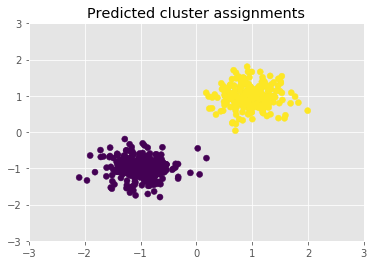

In [18]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()